# Método de Welch

Neste notebook avaliamos o método de Welch, uma ferramenta para análise estatística do espectro. Basicamente tomamos transformadas de Fourier de pequenas janelas temporais que vão se deslocando com o tempo e, então, o espectro médio.

In [24]:
# importar as bibliotecas necessárias
import numpy as np # arrays
import matplotlib.pyplot as plt # plots
plt.rcParams.update({'font.size': 14})
from scipy import signal
import IPython.display as ipd # to play signalsa
import sounddevice as sd
import soundfile as sf

# Intuição

Vejamos uma intuição sobre o método de Welch.

# Os parâmetros do  auto-espectro e espectro cruzado

Dê uma olhada na documentação do scipy:
https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.csd.html


- Os sinais, $x(t)$ e $y(t)$ no tempo
- A frequência de amostragem
- window: A janela temporal desejada
- Overlap: Número de pontos em que teremos uma sobreposição das janelas.
- nfft: Número de pontos da fft (zero padding). Se não for fornecido, é o número de pontos na janela temporal.

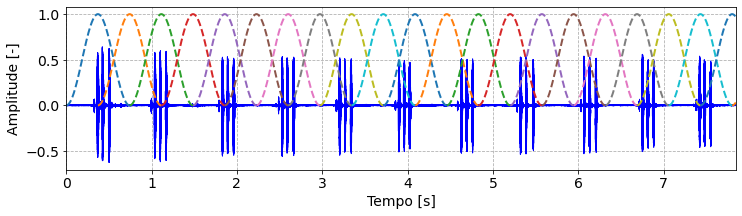

# Exemplo 1: O ruído de uma bomba d'agua

O sinal tem 48.63 [s]


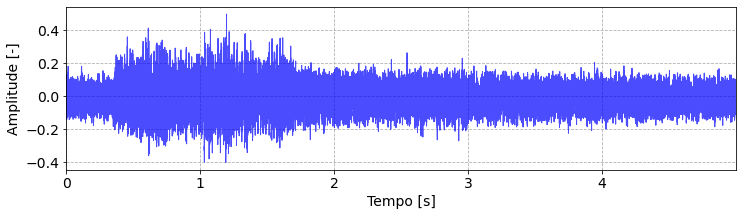

In [25]:
##### x(t) water pump #################
xg, Fs = sf.read('waterpump.wav')
print("O sinal tem {:.2f} [s]".format((len(xg)-1)/Fs))

ti = 0
tp = 5
xt = xg[int(ti*Fs):int(tp*Fs),0]
time = np.linspace(0, (len(xt)-1)/Fs, len(xt))

#plot
plt.figure(figsize=(12,3))
plt.plot(time, xt, '-b',linewidth = 1, alpha = 0.7)
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [-]')
plt.xlim((0, time[-1]))


ipd.Audio(xt, rate=Fs) # load a NumPy array

# Cálculos dos espectros

Vamos calcular:

- Via uma FFT direta no sinal
- Via método de Welch

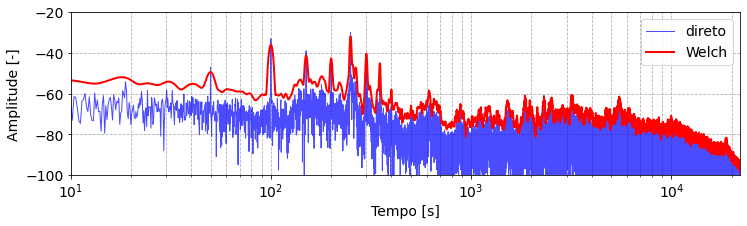

In [26]:
# Método direto
Xw = np.fft.fft(xt)
Xw2 = (np.abs(Xw)/len(Xw))**2
freq = np.linspace(0, (len(Xw)-1)*Fs/len(Xw), len(Xw))

# Método de Welch
win_size = 2*8192
win = signal.windows.hann(win_size)
noverlap = win_size/2
nfft = 8*win_size
f, Sxx = signal.csd(xt, xt, Fs, window = win, noverlap = noverlap, nfft = nfft, scaling = 'density')

# plots
plt.figure(figsize=(12,3))
plt.semilogx(freq, 10*np.log10(Xw2), '-b',linewidth = 1, alpha = 0.7, label = 'direto')
plt.semilogx(f, 10*np.log10(Sxx), '-r',linewidth = 2,  label = 'Welch')
plt.legend(loc = 'upper right')
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [-]')
plt.xlim((10, Fs/2))
plt.ylim((-100, -20));

# Exemplo 2 - O ruído branco

Vimos nas aulas passadas que o ruído branco tem uma auto-correlação do tipo impulsiva.

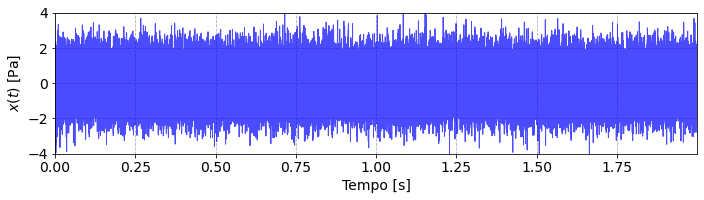

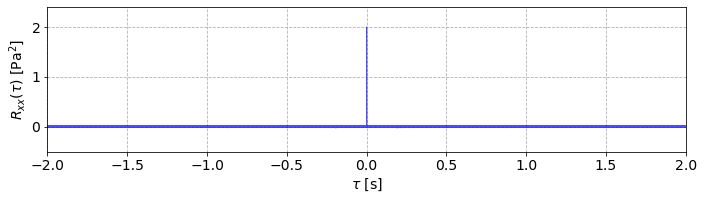

In [27]:
fs = 44100
time = np.arange(0, 2, 1/fs)

# sinal aleatório completo
xt = np.random.normal(loc = 0, scale = 1, size = len(time))

# plot signal
plt.figure(figsize = (10, 3))
plt.plot(time, xt, linewidth = 1, color = 'b', alpha = 0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$x(t)$ [Pa]')
plt.xlim((0, time[-1]))
plt.ylim((-4, 4))
plt.xlabel('Tempo [s]')
plt.tight_layout()

# Calculemos a auto-correlação
Rxx = np.correlate(xt, xt, mode = 'same')
tau = np.linspace(-len(Rxx)/fs, len(Rxx)/fs, len(Rxx))

# plot autocorrelação
plt.figure(figsize = (10, 3))
plt.plot(tau, Rxx/fs, linewidth = 1, color = 'b', alpha = 0.7)
plt.grid(linestyle = '--', which='both')
plt.ylabel(r'$R_{xx}(\tau)$ [Pa$^2$]')
plt.xlim((tau[0], tau[-1]))
plt.ylim((-0.5, 1.2*max(np.abs(Rxx/fs))))
plt.xlabel(r'$\tau$ [s]')
plt.tight_layout()

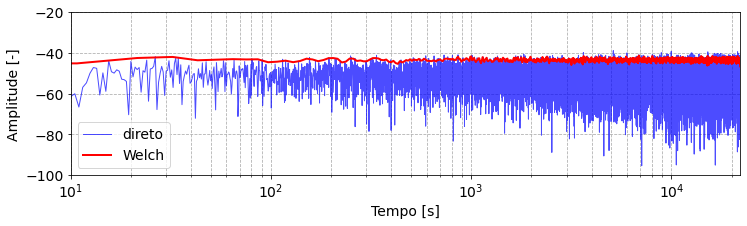

In [28]:
# Método direto
Xw = np.fft.fft(xt)
Xw2 = (np.abs(Xw)/len(Xw))**2
freq = np.linspace(0, (len(Xw)-1)*Fs/len(Xw), len(Xw))

# Método de Welch
win_size = 4096
win = signal.windows.hann(win_size)
noverlap = win_size/2
nfft = win_size
f, Sxx = signal.csd(xt, xt, Fs, window = win, noverlap = noverlap, nfft = nfft, scaling = 'density')

# plots
plt.figure(figsize=(12,3))
plt.semilogx(freq, 10*np.log10(Xw2), '-b',linewidth = 1, alpha = 0.7, label = 'direto')
plt.semilogx(f, 10*np.log10(Sxx), '-r',linewidth = 2,  label = 'Welch')
plt.legend(loc = 'lower left')
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [-]')
plt.xlim((10, Fs/2))
plt.ylim((-100, -20));

# Exemplo 3 - Seno contaminado por ruído

Consideremos um sinal senoidal contaminado por ruído. Temos que

\begin{equation}
x(t) = s(t) + n(t),
\end{equation}
com

\begin{equation}
s(t) = A \mathrm{sin}(2\pi f t + \phi)
\end{equation}

e $n(t)$ um sinal aleatório com distribuição normal. A autocorrelação de $x(t)$ é dada por
\begin{equation}
R_{xx}(\tau) = R_{ss}(\tau) + R_{nn}(\tau)
\end{equation}


Note que $R_{nn}(\tau)$ é um sinal impulsivo como do exemplo anterior e que

\begin{equation}
R_{ss}(\tau) = \frac{A^2}{2}\mathrm{cos}(2\pi f \tau),
\end{equation}
uma função cossenoidal desprovida da informação de fase de $s(t)$. Vamos tomar o auto-espectro do sinal contaminado e comparar com o espectro calculado de maneira direta. Note que a ***TF*** da auto-correlação vai conter informações sobre o cosseno e sobre o ruído. 

\begin{equation}
\mathcal{F}[R_{xx}(\tau)] = \mathcal{F}[R_{ss}(\tau)] + \mathcal{F}[R_{nn}(\tau)]
\end{equation} 


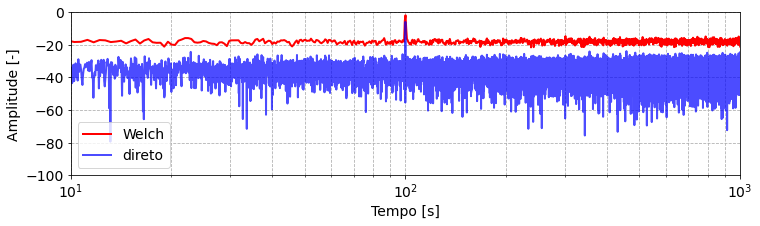

In [31]:
fs = 2000
time = np.arange(0, 20, 1/fs)

# sinal aleatório completo
st = np.sin(2*np.pi*100*time + np.pi/3)
nt = np.random.normal(loc = 0, scale = 4, size = len(time))
xt = st + nt

# Vamos tomar a fft de maneira direta
Xw = np.fft.fft(xt)
Xw2 = (np.abs(Xw)/len(Xw))**2
freq = np.linspace(0, (len(Xw)-1)*fs/len(Xw), len(Xw))

# Vamos calcular o auto-espectro usando o Método de Welch
win_size = 4096
win = signal.windows.hann(win_size)
noverlap = win_size/2
nfft = win_size
f, Sxx = signal.csd(xt, xt, fs, window = win, noverlap = noverlap, nfft = nfft, scaling = 'density')

# plots
plt.figure(figsize=(12,3))
plt.semilogx(f, 10*np.log10(Sxx), '-r',linewidth = 2,  label = 'Welch')
plt.semilogx(freq, 10*np.log10(Xw2), '-b',linewidth = 2, alpha = 0.7, label = 'direto')
plt.legend(loc = 'lower left')
plt.grid(linestyle = '--', which='both')
plt.xlabel('Tempo [s]')
plt.ylabel('Amplitude [-]')
plt.xlim((10, fs/2))
plt.ylim((-100, 0));